# Calibration View

In [2]:
from config.settings import OutPath, PlotsPath, positions, linear_popt
from config.plot_config import set_plot_style; set_plot_style()

from utils.functions import linear
from utils.functions import gaussian

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

In [3]:
#plot params
label_fontsize = 18
plt.rcParams["xtick.labelsize"] = label_fontsize
plt.rcParams["ytick.labelsize"] = label_fontsize

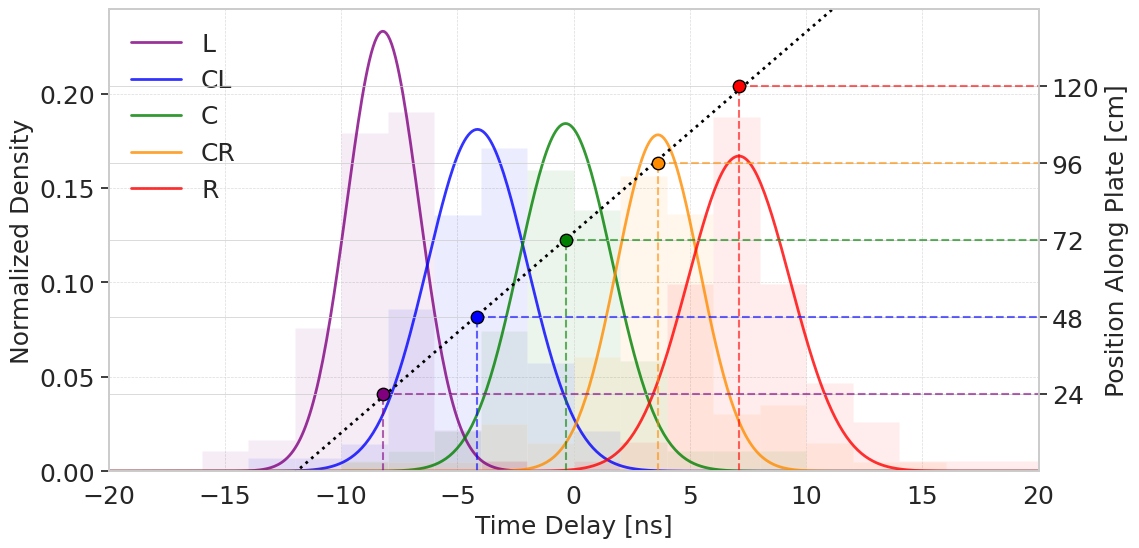

In [6]:
# File Paths and Labels
x_positions = [24, 48, 72, 96, 120]
colors = ['purple', 'blue', 'green', 'darkorange', 'red']
labels = ['L', 'CL', 'C', 'CR', 'R']
histograms = []
mean_values = []

# Load histograms from .npy files
for label in labels:
    file_path = os.path.join(OutPath, f"{label}.npy")
    histograms.append(np.load(file_path))

# Initialize figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histograms with improved transparency
bins = np.arange(-20, 21, 2)
for i, hist in enumerate(histograms):
    ax.hist(hist, bins=bins, alpha=0.075, density=True, color=colors[i]) #, label=f"{labels[i]} Histogram")

# Initial Gaussian fit parameters
initial_guesses = [[25, -5, 2], [25, -2, 2], [25, 0, 2], [25, 2, 2], [25, 5, 2]]
bins = np.arange(-20.5, 20.5, 1)

# Fit each histogram with a Gaussian
for idx, hist in enumerate(histograms):
    hist_counts, bin_edges = np.histogram(hist, bins=bins, density=True)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    popt, _ = curve_fit(gaussian, bin_centers, hist_counts, p0=initial_guesses[idx])

    mean_values.append(popt[1])

    # Smooth Gaussian curve
    x_vals = np.linspace(-20, 20, 500)
    ax.plot(x_vals, gaussian(x_vals, *popt), label=f"{labels[idx]}", color=colors[idx], alpha=0.8, linewidth=2)

# Formatting primary axis (Histograms)
ax.set_xlim(-20,20)
ax.set_xlabel("Time Delay [ns]", fontsize=label_fontsize)
ax.set_ylabel("Normalized Density", fontsize=label_fontsize)
ax.legend(loc="upper left", fontsize=18, frameon=False)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Secondary Y-axis for mean positions
ax2 = ax.twinx()

# Scatter plot of Gaussian means with enhancements
for i, mean in enumerate(mean_values):
    ax2.scatter(mean, x_positions[i], color=colors[i], edgecolor='black', s=80, zorder=3)
    
    # Horizontal line extending from mean value to twin y-axis
    ax2.plot([mean, 20], [x_positions[i], x_positions[i]], linestyle="dashed", color=colors[i], alpha=0.6)

    ax2.plot([mean, mean], [0, x_positions[i]], linestyle="dashed", color=colors[i], alpha=0.6)

# Linear fit line
t_vals = np.linspace(-12, 12, 100)
ax2.plot(t_vals, linear(t_vals, *linear_popt), color='black', linestyle='dotted', linewidth=2, label = "Linear Fit")

# Formatting secondary axis
ax2.set_ylabel("Position Along Plate [cm]", fontsize=label_fontsize)
ax2.set_ylim(0, 144)
ax2.set_yticks(x_positions)

savefig = os.path.join(PlotsPath, 'calib_nice.png')
plt.savefig(savefig, dpi = 450)

plt.show()

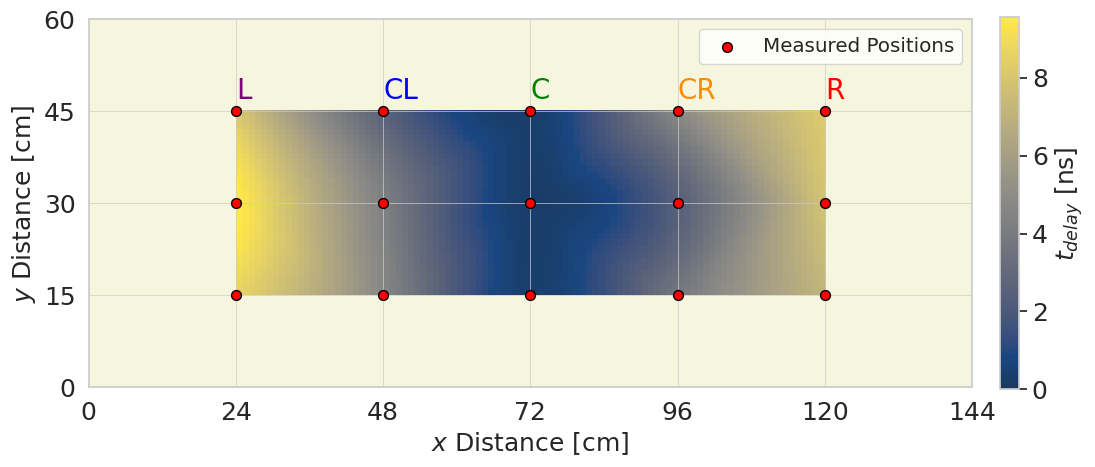

In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define measures and coordinates
measures = ["L1", "L2", "L3", "CL1", "CL2", "C1", "C2", "C3", "CR1", "CR2", "CR3", "R1", "R2", "R3"]
coords   = np.array([
    [24, 15], [24, 30], [24, 45], [48, 15], [48, 30],
    [72, 15], [72, 30], [72, 45], [96, 15], [96, 30], 
    [96, 45], [120, 15], [120, 30], [120, 45]
])

# Load values
vals = []
for measure in measures:
    file_path = os.path.join(OutPath, f"{measure}.npy")
    arr = np.load(file_path)
    val = np.abs(np.mean(arr))
    vals.append(val)

vals = np.array(vals)

# Create a grid covering the whole heatmap area
grid_x, grid_y = np.mgrid[0:144:144j, 0:60:60j]  # Adjust range and resolution

# Interpolate using 'cubic' for smooth results
grid_z = griddata(coords, vals, (grid_x, grid_y), method='cubic')

# 🔹 Mask NaN values (outside the interpolation range) and set them to black
masked_grid_z = np.where(np.isnan(grid_z), -1, grid_z)  # Set NaN to -1 as a placeholder

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 5))

# Define a colormap where -1 (NaN) is forced to black
cmap = plt.cm.cividis
cmap.set_under('#F5F5DC')  # This sets out-of-range (masked) areas to black

# Use `vmin` to ensure -1 is treated as out-of-range
c = ax.imshow(masked_grid_z.T, extent=(0, 144, 0, 60), origin='lower', cmap=cmap, alpha=0.9, vmin=0)

# Scatter points
ax.scatter(coords[:, 0], coords[:, 1], color='red', edgecolors='black', s=50, label="Measured Positions")
ax.scatter(48, 45, color='red', edgecolors='black', s=50)

# Adjust colorbar height to match the y-axis
cbar = ax.figure.colorbar(c, ax=ax, fraction=0.02, pad=0.03)  # fraction controls the height
cbar.set_label(r"$t_{delay}$ [ns]", fontsize=label_fontsize)

# Labels and title
ax.set_xlabel(r"$x$ Distance [cm]", fontsize=label_fontsize)
ax.set_ylabel(r"$y$ Distance [cm]", fontsize=label_fontsize)

ax.set_xticks([0, 24, 48, 72, 96, 120, 144], labels = [0, 24, 48, 72, 96, 120, 144])
ax.set_yticks([0,15,30,45,60], labels = [0,15,30,45,60])

ax.text(24, 47, "L", fontsize=20, color=colors[0])
ax.text(48, 47, "CL", fontsize=20, color=colors[1])
ax.text(72, 47, "C", fontsize=20, color=colors[2])
ax.text(96, 47, "CR", fontsize=20, color=colors[3])
ax.text(120, 47, "R", fontsize=20, color=colors[4])

#ax.set_title("Interpolated Heatmap from Scattered Points", fontsize=16)
ax.legend()

# Linear fit line
t_vals = np.linspace(-12, 12, 100)
ax2.plot(t_vals, linear(t_vals, *linear_popt), color='black', linestyle='dotted', linewidth=2, label = "Linear Fit")

savepath = os.path.join(PlotsPath, "calib_heatmap.png")
plt.savefig(savepath, dpi = 450)
plt.show()

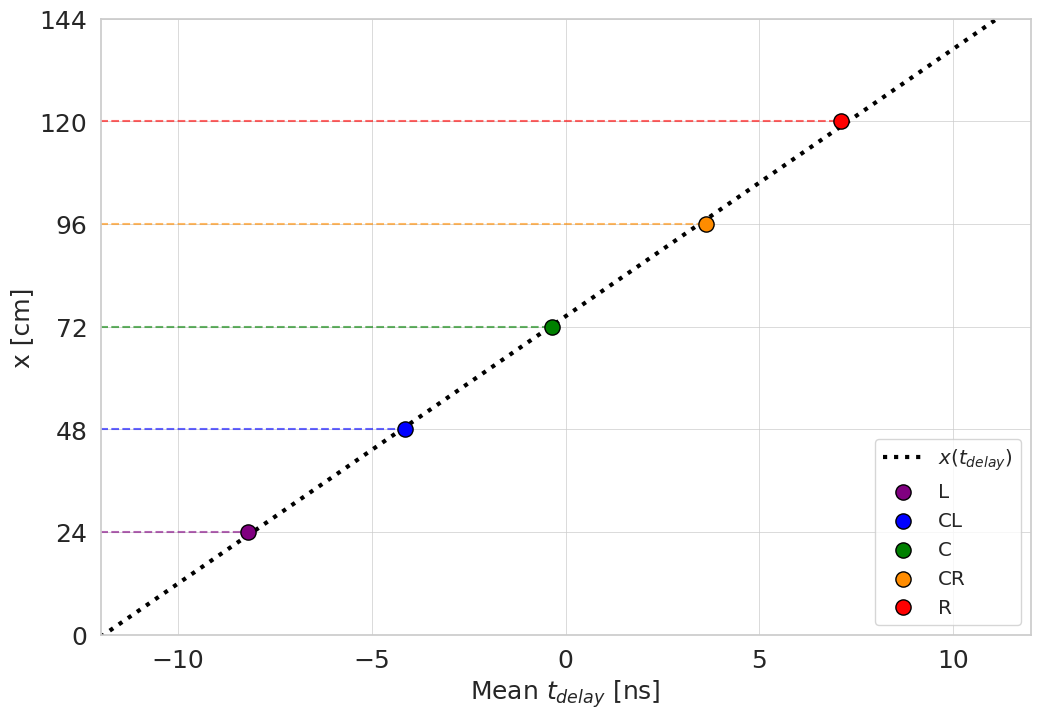

In [130]:
fig, ax = plt.subplots(figsize=(12,8))

# Linear fit line
t_vals = np.linspace(-12, 12, 100)
ax.plot(t_vals, linear(t_vals, *linear_popt), color='black', linestyle='dotted', linewidth=3, label = r"$x(t_{delay})$")

# Scatter plot of Gaussian means with enhancements
for i, mean in enumerate(mean_values):
    ax.scatter(mean, x_positions[i], color=colors[i], edgecolor='black', s=120, zorder=3, label = labels[i])
    
    # Horizontal line extending from mean value to twin y-axis
    ax.plot([-14, mean], [x_positions[i], x_positions[i]], linestyle="dashed", color=colors[i], alpha=0.6)


ax.set_xlabel(r"Mean $t_{delay}$ [ns]", fontsize=label_fontsize)
ax.set_ylabel("x [cm]", fontsize=label_fontsize)

ax.set_yticks([0, 24, 48, 72, 96, 120, 144], labels = [0, 24, 48, 72, 96, 120, 144])

ax.set_xlim(-12,12)
ax.set_ylim(0,144)
ax.legend()

savepath = os.path.join(PlotsPath, "calib_linear_fit.png")
plt.savefig(savepath, dpi = 450)
plt.show()

fig.tight_layout();

In [14]:
from scipy.interpolate import interp1d

t1 = np.linspace(-12,12)
x_t = linear(t1, *linear_popt)

fun = interp1d(t1, x_t)

In [20]:
dt = 1.1
dx = fun(2) - fun(2 - dt)
dx

np.float64(6.871510811974915)